# Predicting Student Success Using Virtual Learning Environment Interaction Statistics

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential, load_model
from keras import optimizers, layers
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, cross_val_presentation, GridSearchPresentationCV, \
registration_correlations, dist_by_course

from dython.nominal import associations

import pickle

import warnings

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)
sns.set(font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction:

![empty computer](../figures/goran-ivos-empty-computer-unsplash.jpg)

## The Problem
Online learning has been a growing and maturing industry for years now, and in a way, the internet has always been about learning.  [Khan Academy](https://www.khanacademy.org/) was, to me, a quintessential step in self-driven learning and massive open online courses (MOOCs) like [Coursera](https://www.coursera.org/) create an even more structured approaches to online, self-driven learning.  I took my first online course on coding fundamentals from [edX](https://www.edx.org/) in 2013 and started my data science journey in 2019 on Coursera.

While these are an amazing resources, they also have high dropout and failure rates.  Many students, accustomed to the accountability features in traditional face-to-face learning, struggle with the openness of these systems and the lack accountability.  In self-driven learning, it can be easy to get lost or give up.

## The Solution

I set out to find ways to use data to help students succeed by identifying those who are in danger of failing or withdrawing early.  Many students in need of special intervention to improve their chances of success can be identified by the way they interact with the online learning system itself.  

The goal of this project is to model student interactions with an online learning environment to predict whether they will ultimately pass or fail a course early enouth for intervention to be effective.  My model captures the underlying patterns of behavior that predict the success of students in any self-paced online learning environment.

In order to simulate this kind of prediction, I fit a model on chronologically earlier cohorts of students, their behavior and outcomes, and then validate my model on the latest cohorts present in the dataset.

# The Data
I use a dataset from [Open University](http://www.openuniversity.edu/) based in Great Britain.  They are an entirely online university offering accredited degrees to distance learners.  They released anonymized data from seven courses, three from the social sciences and four STEM courses, taught in four repetitions during the 2013 and 2014 academic years.  These courses are repeated twice per year, a February cohort labeled "B" and an October cohort labeled "J".  Each repetition is called a 'presentation'. The presentations are 2013B, 2013J, 2014B, and 2014J.  Not all presentations of each course are included in the dataset, as not all have enough students to make statistically signficant generalizations.  

To learn more about how the data was selected and anonymised visit [US National Institute of Health](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5704676/),

While this dataset contains regional, demographic, and personal data about students, I am only interested in data about how students interacted with the learning environment and how they performed.  

**Interactions**
The university provided interaction information each activity that each student engaged.  This include the date and number of clicks on that activity in StudentVle.csv available in the [anonymiseData.zip](content/anonymisedData.zip) file in the form of individual activity engagements. I aggregated those interactions into the following three features:

1. Number of total clicks during the presentation of the course.
2. Number of total activities completed
3. Number of days worked

It was the last statistic that I felt would be uniquely predictive.  I spent 14 years teaching students and one thing I learned from research and experience is that spreading learning out over more days, rather than cramming more learning on fewer days, helps with persistence and with learning retention.  Building a routine of study builds learning into a hab.  We are creatures of habit and habits persist.  On the other hand, cramming learning into fewer days is more exhausting and less pleasant, creating a sense of aversion to the act.  Frequent reinforcement of learning also serves to reinforce neuronal axons that are the physical manifestation of learning.

**Assessments**
The next statistics I used were from studentAssessments.csv and represented the percentage of total assessments completed before the prediction was made, and the average score of those assessments.  These assessments include both practice tests and graded tests.

*Assessment Statistics*
4. Average assessment score.
5. Percent of total assessments completed.

The first was an obvious choice, and the second is meaningful because these courses were self-paced and some students completed more assessments than others.  Most of the variance is in the practice tests. 

#  Data Preparation
I took several steps in order to prepare the data for exploration and modeling.

1. I merged the 7 tables in the provided zip file.
2. I cleaned the data of rows with values missing in important columns, or suspicious values such as student withdrawing before they register or withdrawing after the end of the course.
3. I extracted statistics on the virtual learning environment interaction data as new features, see above.
4. I extracted statistics on assessments as new features, see above.
5. I limited the data returned to that which would be available during a given prediction window.  I also exclude students who have withdrawn from the course before the prediction window, since their outcomes is already known. This adjustable window allows for predictions to be made at particular points in the course.  Predicting later in the course increases model accuracy while predicting earlier allows for earlier intervention and the possibility of interventions for students who would withdraw earlier in the course. 

# Data Exploration
Let's take a look at the shape and general statistics of the data.
We will drop the columns our model will not use.  They were useful to explore some correlations between demographics and outcomes, but are not relevant to our actual modeling.  If you want to see more about what I found in that exploration, please see my [EDA notebook](../notebooks/OU_eda.ipynb)

Here I will focus on correlations within the activity and assessment statistics that I will be using for modeling.  

The data below represent the entire dataset, not just the prediction window I will be using for modeling.

In [3]:
df = load_OU_data(prediction_window = .5)
df.drop(columns = ['id_student','region','highest_education',\
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration', 'num_of_prev_attempts'], inplace = True)
if 'date_unregistration' in df.columns:
    df.drop(columns = ['date_unregistration'], inplace = True)
df.head()

,code_module,code_presentation,final_result,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,2013J,Pass,26.0,121.0,628.0,0.500000,81.000000
1,AAA,2013J,Pass,45.0,266.0,896.0,0.333333,69.000000
2,AAA,2013J,Pass,68.0,371.0,1231.0,0.500000,72.333333
3,AAA,2013J,Pass,40.0,207.0,747.0,0.333333,49.500000
4,AAA,2013J,Pass,70.0,365.0,1271.0,0.500000,74.000000


In [4]:
df.describe()

,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
count,23865.000000,23865.000000,23865.000000,23865.000000,23865.000000
mean,39.778588,238.641735,847.138613,0.350930,70.253045
std,28.876075,221.817777,1018.198547,0.162653,23.883125
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,81.000000,222.000000,0.230769,64.250000
50%,34.000000,175.000000,518.000000,0.400000,77.333333
75%,57.000000,325.000000,1077.000000,0.461538,85.600000
max,142.000000,1790.000000,13973.000000,0.923077,100.000000


We see here some very large standard deviations in some of these statistics.  Notice that `total_clicks` ranges from 1 to 24139 and activities engaged ranges from 1 to 3078.  


## Correlations in the Full Dataset:
I am indebted to Shaked Zychlinsk and his [dython module](https://github.com/shakedzy/dython) for the below correlation matrix function, which uses his `associations()` function internally.  Please refer to the documentation of the `dython.nominal.associations` to see how it chooses the right kind of correlation for each box, depending on whether its categorical/categorical, nominal/categorical, or nominal/nominal.

One note: `registration_correlations()` is turning `final_results` into a nominal variable with higher numbers being better outcomes.  This helps us see not just how much another variable affects the results, but in what direction it drives it.

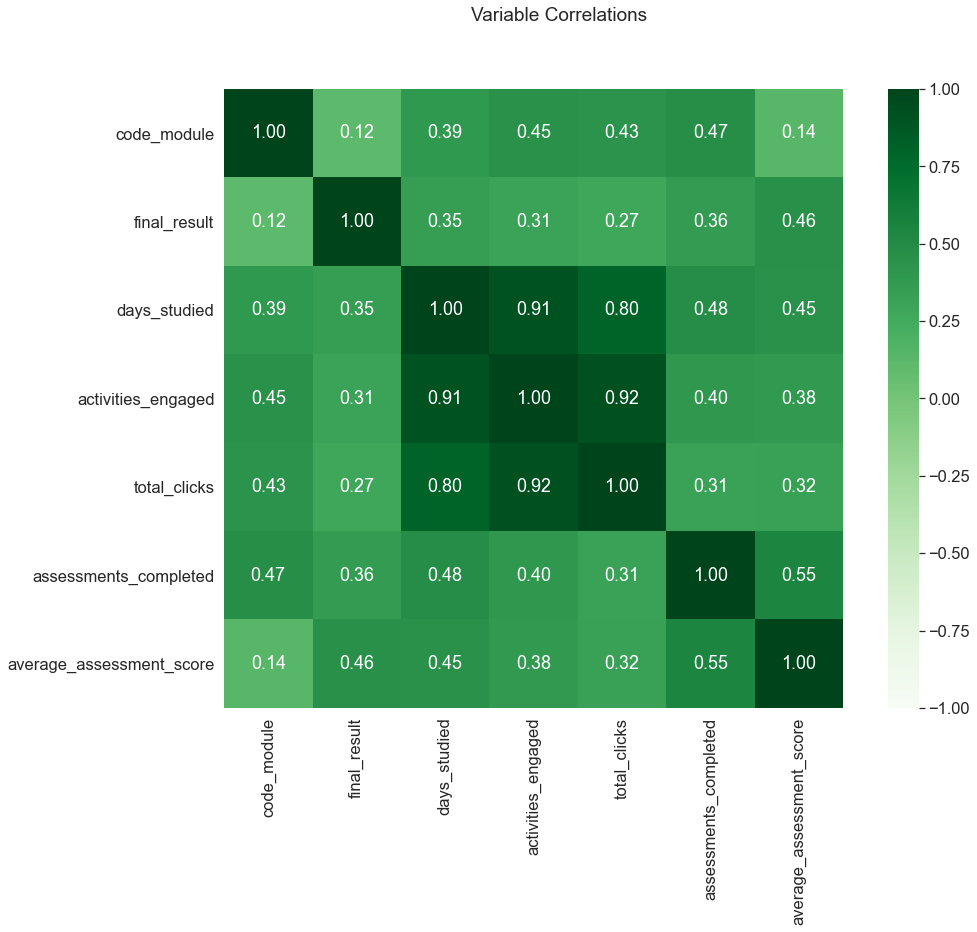

In [5]:
registration_correlations(df, cmap = 'Greens', save_path = '../figures/coursecorr.png')

### The good news and the bad news
**First the good**

1. All of our activity and assessment statistics have strong correlations with the final result.

2. `days_studied` is only topped by number of assessments completed for most correlated, which follows with my own experience as a teacher and learner.

3. `total_clicks` is not as highly correlated as the other activity statistics.  This is interesting and may be an area of future study.

**Now the bad**

1. Our activity stats are all very highly correlated to each other, and this stands to reason.  The more days you study, the more activities you engage.  The more activities you engage, the more times you click.  `assessments_completed` and `average_assessment_score` are also correlated, but not as strongly as one might thing.  This high correlation between features would be a problem if we were doing inferential modeling, such as OLS, but it's fine for predictive modeling.

2. The activity stats and assessment stats are correlated to `code_module`.  Since we want to generalize this model to predict across multiple courses, the courses need to be normalized.

3. `final_result` is also correlated to `code_module`, which presents another problem.  The correlation to our target variable is a separate problem from the correlation to our predictor variables, and I will address these troublesome groupings in my data preprocessing later in this notebook.

# Preprocessing
I told you some about preparing the data, but there is more to do to overcome the problems mentioned above.

1. I limit the data to what makes sense for our prediction window, or the points in the course we want to make our predictions on.  I remove students who have already withdrawn and won't use any data that we would not yet have by that point in the course.

2. The outcomes in the original dataset are 'Distinction', 'Pass', 'Fail', and 'Withdrawn'.  However, this prediction model only predicts whether a student needs intervention or not.  Those passing or passing with distinction do not need interventions, while those failing or withdrawing do.  I combine the first two into a new class 'No Intervention' and the second two into 'Needs Intervention'.  This makes the target binary, easier to predict and easier to evaluate.  There is an argument for separating withdrawing students and failing students, but my model is not accurate at differentiating between those.  

3. I scale all the data for each course separately.  The `CourseScaler` class object fits on each individual course, as indexed by the `code_module` variable.  It stores the mean and standard deviation for each feature for each course from the training data and uses those to scale each feature for each individual course `(X - mean) / standard deviation` in both the training and the validation data.  This removes the correlations between `code_module` and the activity and assessment statistics without leaking information from our training set into our validation data..

4. I use the `smotecourses()` function to apply [imblearn.over_sampling.SMOTE](https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTE.html) to the training data to create synthetic data within the minority class for balance.  Each course in the training set then has an equal number of students needing intervention and not needing interventions, even though some of those students are not real, but approximations.  This removes the correlation between `code_module` and `final_result`, further generalizing the model.  

5. Once those are done, we can drop the `code_module` column, because we don't want our model considering that in its predictions.

## Scaling
By scaling the data by course we have removed the correlations along the top row for most variables.  the only thing left is the target variable, `final_result`.  We can take care of that by balancing the classes in each course.  It has also changes strengths of the correlations. 

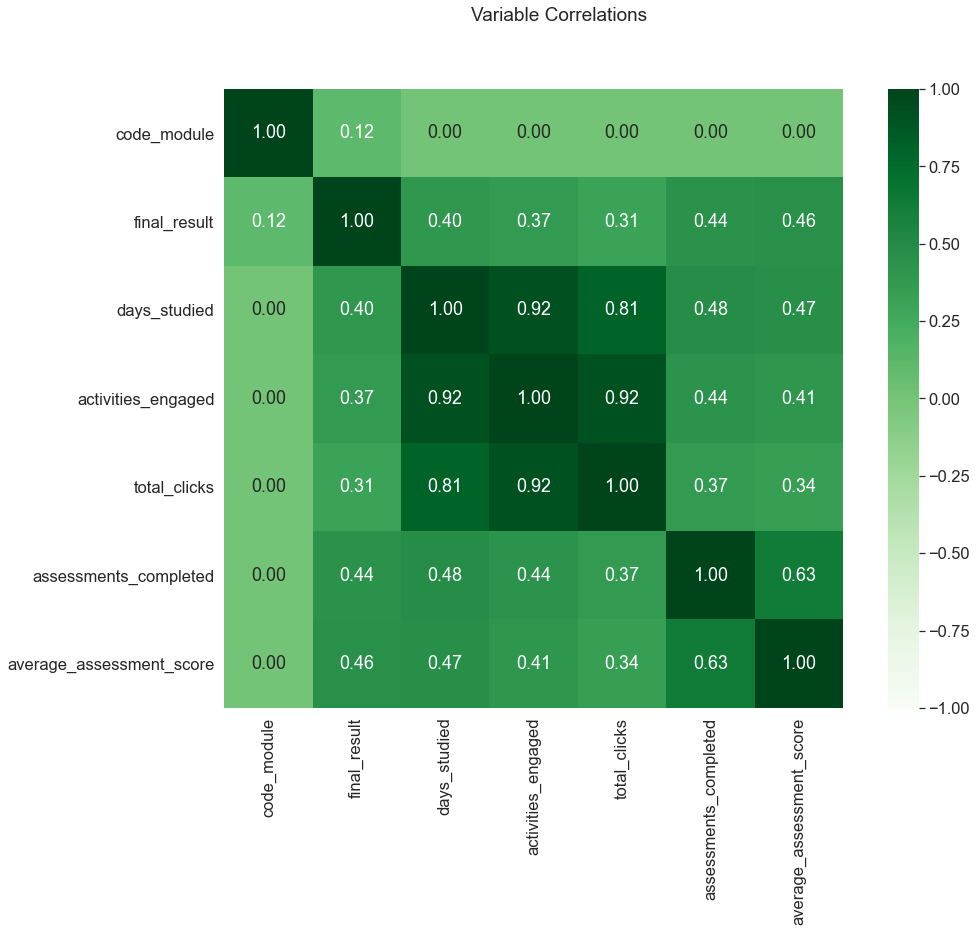

In [6]:
#Setting prediction_window to .5 loads data up to the halfway point of the shortest course present
#Scale the variables, but keep `code_module` for comparing
cs = CourseScaler(drop_course=False)
scaled_df = cs.fit_transform(df)

#create the new correlation matrix
registration_correlations(scaled_df, cmap = 'Greens', save_path = '../figures/scaledcoursecorr.png')

## SMOTE-ing
This approach creates synthetic data is that is similar, but not identicial to observations in the minority class of students to balance the classes and prevent the model from over-predicting one class to get better accuracy.  Otherwise the model decides that the safer choice, when in doubt, is to guess an observation belongs to the class with the most observations, introducing unwanted bias. 

The smoting process adds a small amount of residual correlation between the `code_module` and some of the features, but nothing significant.  There is now no correlation between the specific courses and our target variable, `final_result`

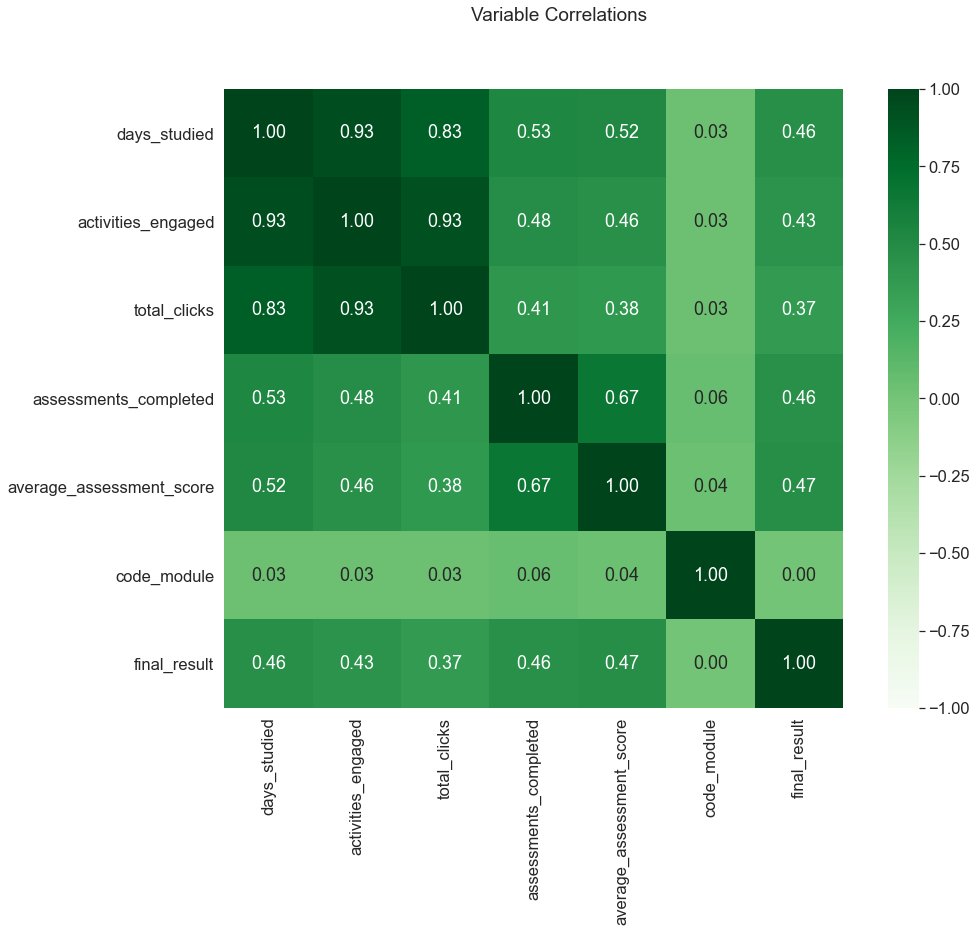

In [7]:
demo_X = scaled_df.drop(['code_presentation','final_result'], axis=1)
demo_y = scaled_df['final_result']

smoted_X, smoted_y = smotecourses(demo_X, demo_y, drop_course=False)
smoted_X['final_result'] = smoted_y
registration_correlations(smoted_X, cmap='Greens', save_path = '../figures/scaled_smoted_coursecorrs.png')

# Modeling
The heavy lifting here was in the data preparation and preprocessing.  We will try a few different models, a logistic regression for a baseline FSM, K-nearest neighbors, and then some tree based models, a decision tree, a random forest, an eXtreme Gradient Boost model (because Kagglers love them!), and a support vector machine.

I used a custom GridSearchPresentationCV class to do a grid based hyperparameter search to help me set good hyperparameters for each of these.  This was needed because my scaler and smoter each need the `code_module` feature in order to do their work, but need to remove it before modeling.  This was not possible to do with the sklearn or imblearn pipelines or with with the cross validation functions they offer.  So, I wrote my own.  

I won't show the whole grid search process here, but if you'd like to see how I did it, please visit my [model development notebook](../notebooks/shallow_modeling.ipynb). You can also find a brief discussion of how each model works and links to more information there.

## Train/Test Split
Our goal is to predict, for a current cohort of students, who should receive additional attention or intervention.  We want to ration resources and avoid disrupting students who are already on track to pass with extra distractors.  If this model were deployed, it would be using past data to predict future data.  For this reason, instead of a traditional random sampling for splitting our training and testing data, we will be using data from presentations 2013B, 2013J, and 2014B as our training set and holding out course presentations 2014J for final model validation.  Cross validation will be performed by holding out each presentation in the training set, training on the remaining presentations, and then predicting on the held out presentation I'll report the accuracy of the model on each presentation of each course, as well as an average across presentations in the training set.  Finally I will report each model's score on all students in 2014J cohorts for all classes.  

Courses that have only one one presentation can't be used for validation because my model requires each course to be scaled by fitting on presentations of that course within the training set.  If a course presentation is in a validation set, but there are no examples of that course in the training set, I can't scale it correctly without data leakage.

In [8]:
test_df = df[df['code_presentation'] == '2014J']
train_df = df[df['code_presentation'] != '2014J']

# for error analysis later
y_test_uncollapsed = test_df['final_result'].reset_index(drop=True)

#collapse results into two classes
train_df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in train_df['final_result']])
test_df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in test_df['final_result']])

X_train = train_df.drop(columns = ['final_result','code_presentation'])
y_train = train_df['final_result']
X_test = test_df.drop(columns = ['final_result','code_presentation'])
y_test = test_df['final_result']

#the cross validator processes data as it's validating, but we want a set for final evaluation, too.
X_train_transformed, y_train_transformed, X_test_transformed \
                                = process_courses(X_train, y_train, X_test)

## Logistic Regression
A logistic regression model creates a best-fit line through the data to model a linear relationship between the variables and the target.  It then applies a sigmoid function to that line to assign, for each data point in the test set, a probability that it falls into a given class.  Which class is chosen is a function of a probability threshold which can be adjusted.  For this model if an observation has a greater than 50% chance of being a member of a class, it is assigned to that class.  If I wanted to adjust the distribution of our errors, I could adjust this threshold, and this may be a choice in future deployment situations.

Model Hyperparamters:
LogisticRegression(C=0.1, l1_ratio=0.9, penalty='l1', random_state=111,
                   solver='liblinear')
Validation scores across folds are:


score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.805576
            2013J              0.772754
            2014B               0.80779
CCC         2014B                   NaN
DDD         2013B              0.779303
            2013J              0.784483
            2014B              0.828605
EEE         2013J              0.777506
            2014B              0.856354
FFF         2013B               0.78554
            2013J              0.779174
            2014B              0.790235
GGG         2013J              0.692393
            2014B               0.80491

Mean validation scores is:
0.7895863450455931
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.62      0.67      0.64      2735
   No Intervention       0.82      0.78      0.80      5195

          accuracy                           0.74      7930
         macro avg       0.72      0.73      0.72      7930
      weighted avg       0.75      0.74      0.75      7930



<AxesSubplot:>

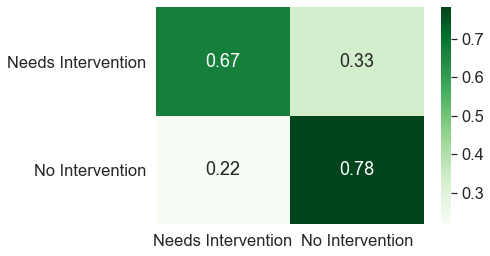

In [9]:
model = pickle.load(open('../models/LRmodel3.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = cross_val_presentation(model, train_df, scoring='accuracy')
print('Validation scores across folds are:')
display(scores)
print('Mean validation scores is:')
print(np.mean(scores.score))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred)

### Logistic Regression Evaluation
The logistic regression model seems to perform much better on cross validation than the 2014J hold out.  I used a gridsearch algorithm to search for good regularization hyperparameters, but have not been able to remove that overfitting.  This is present in all of my models.  It may be that 2014J is different enough from previous cohorts that the model's can't overcome this.  By looking at the cross-validation accuracy among the presentations in the training data, you can see that the model accuracy ranges from 70% - 82%.  The model is more accurate for some cohorts than others.

This model correctly identifies 68% of students in need of intervention while misclassifying 23% of successful students as in need of intervention.  Overall accuracy is 74% with a bias toward predicting students will not need intervention.

# K-Nearest Neighbors
In this model training observations are arranged in n-dimensional space, where n is the number of features.  Testing observations are classified by counting the k number of closest observations of each class and assigning to the class with the highest such count.

Model Hyperparamters:
KNeighborsClassifier(n_jobs=-1, n_neighbors=300, p=20)
Validation scores across folds are:


score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.804842
            2013J              0.781083
            2014B              0.811177
CCC         2014B                   NaN
DDD         2013B              0.767687
            2013J              0.789511
            2014B              0.827423
EEE         2013J              0.789731
            2014B              0.847145
FFF         2013B              0.770106
            2013J              0.773788
            2014B              0.781193
GGG         2013J              0.701213
            2014B              0.806202

Mean validation scores is:
0.7885463183546009
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.61      0.67      0.64      2735
   No Intervention       0.82      0.78      0.80      5195

          accuracy                           0.74      7930
         macro avg       0.71      0.72      0.72      7930
      weighted avg       0.75      0.74      0.74      7930



<AxesSubplot:>

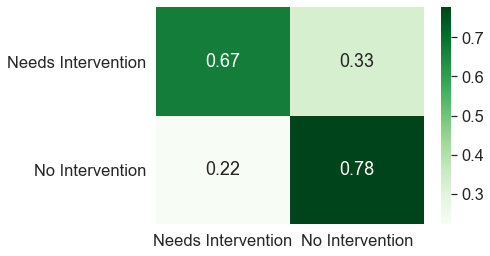

In [10]:
model = pickle.load(open('../models/KNNmodel2.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = cross_val_presentation(model, train_df, scoring='accuracy')
print('Validation scores across folds are:')
display(scores)
print('Mean validation scores is:')
print(np.mean(scores.score))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred)

### KNN Evaluation
The K-nearest neighbors model performed identically to the logistic regression model, despite having a significantly different approach.

## Decision Tree
I decided to try a decision tree next.  This model creates a tree of branching choices.  To decide the class of an observation, variables are examined at each branch and sent down one or the other depending on their value until they reach a terminal node, or a leaf.

Model Hyperparamters:
DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=5,
                       min_samples_split=0.6, random_state=111)
Validation scores across folds are:


score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B                0.7865
            2013J              0.766211
            2014B              0.745131
CCC         2014B                   NaN
DDD         2013B              0.795143
            2013J              0.791667
            2014B              0.794326
EEE         2013J              0.837408
            2014B              0.790055
FFF         2013B              0.800975
            2013J              0.786355
            2014B              0.792948
GGG         2013J              0.693495
            2014B              0.731266

Mean validation scores is:
0.7778061742701877
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.59      0.69      0.64      2735
   No Intervention       0.82      0.75      0.78      5195

          accuracy                           0.73      7930
         macro avg       0.71      0.72      0.71      7930
      weighted avg       0.74      0.73      0.73      7930



<AxesSubplot:>

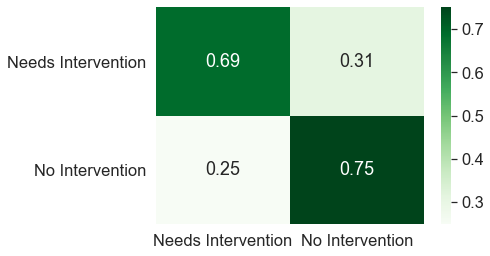

In [11]:
model = pickle.load(open('../models/DTmodel3.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = cross_val_presentation(model, train_df, scoring='accuracy')
print('Validation scores across folds are:')
display(scores)
print('Mean validation scores is:')
print(np.mean(scores.score))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred)

### Decision Tree Evaluation
The decision tree model again performs fairly similarly to the others in over all accuracy, but is slightly more successful at predicting students who need intervention and less accurate for those who do not.  This indicates a less bias for assigning students to the 'No Intervention' class.

## Random Forest
If one decision tree doesn't work, lets try 200 decision trees working together.  This model uses 'bagging', or bootstrap aggregation, to combine the predictions of multiple parallel decision trees.

Model Hyperparamters:
RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_split=0.3,
                       n_estimators=200, n_jobs=-1, random_state=111)
Validation scores across folds are:


score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.802641
            2013J              0.764426
            2014B              0.762913
CCC         2014B                   NaN
DDD         2013B               0.80359
            2013J              0.788075
            2014B              0.803783
EEE         2013J              0.817848
            2014B               0.79558
FFF         2013B              0.796913
            2013J              0.791143
            2014B              0.793852
GGG         2013J              0.703418
            2014B              0.760982

Mean validation scores is:
0.7834741214049464
Evaluation on hold-out set.
                    precision    recall  f1-score   support

Needs Intervention       0.60      0.71      0.65      2735
   No Intervention       0.83      0.75      0.79      5195

          accuracy                           0.73      7930
         macro avg       0.71      0.73      0.72      7930
      weighted avg       0.75      0.73      0.74      7930



<AxesSubplot:>

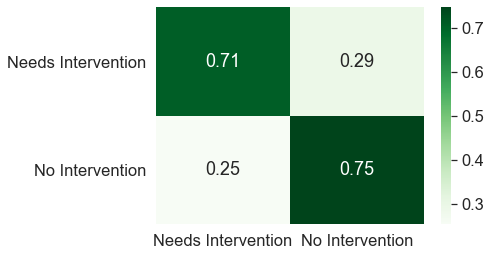

In [12]:
model = pickle.load(open('../models/RFmodel3.pkl','rb'))
print('Model Hyperparamters:')
print(model)
scores = cross_val_presentation(model, train_df, scoring='accuracy')
print('Validation scores across folds are:')
display(scores)
print('Mean validation scores is:')
print(np.mean(scores.score))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred)

Once again, this model shows a similar accuracy to other models, but shows even more bias toward assigning students to 'Needs Intervention', raising both true positive and false positive predictions for that class.

# eXtreme Gradient Boosting
I tried one tree, I tried a forest of trees, let's try stacking trees on top top of each and letting each one boost the one before it.  This is a trendy model these days.  Lets see how it performs.

In [14]:
model = pickle.load(open('../models/XGBmodel5.pkl','rb'))
print('Model Hyperparameters:')
# print(model)
scores = cross_val_presentation(model, train_df, scoring='accuracy')
print('Validation scores across folds are:')
display(scores)
print('Mean validation scores is:')
print(np.mean(scores.score))
model.fit(X_train_transformed, y_train_transformed)
y_pred = model.predict(X_test_transformed)
print('Evaluation on hold-out set.')
print(classification_report(y_test, y_pred))
plot_confusion(y_test, y_pred)

Model Hyperparamters:


AttributeError: 'XGBClassifier' object has no attribute 'use_label_encoder'

## XGBoost Evaluation
This is the model with the highest overall accuracy, though the range of accuracies across models is only 2%.  It shows a strong bias toward predicting students will not need intervention however.  Looking at the dataframe of scores by presentation, this model is, like the others, very inconsistent.


## XGBoost Feature Importance
This model looks especially at assessments to classify students

In [ ]:
from xgboost import plot_importance
model = pickle.load(open('../models/XGBmodel5.pkl','rb'))
plt.figure(figsize = (10,7))
ax = plt.subplot()
plot_importance(model, ax=ax, importance_type = 'gain')
plt.tight_layout()
plt.savefig('../figures/XGB_final_model_feature_importance.png', dpi=100)

While our correlation matrix above told us that, for the scaled and balanced dataset, `days_studied`, `assessments_completed`, and `average_assessment_score` were all pretty equally important, the XGBoost model puts more importance on the number of assessments completed and the assessment scores.  I used 'gain' as the feature importance metric, meaning how much entropy was removed, equivalent to how much information was gained, for branches in the stacked trees that included that variable. Let's take a closer look at the means of these variables for all students in the test set, those who passed, those who failed, those whom the model predicted would pass and those whom the model predicted would fail.

# Deep Learning Model
Deep learning models can often capture relationships between variables that are more abstract or convoluted than shallow models.  My next attempt to model this dataset was a series of neural networks using various sizes and numbers of dense layers.  A dense network model passes all of the independent variables to each of a number of neurons.  Each neuron multiplies all of the independent variables by learned weights numbers and then passes them to all of the neurons in the next layer until the final layer outputs an array of values of the same shape as the dependent variable.  The output of the model is compared to the independent variables of the training set and the difference is used to determine how each of the weights of the hidden layers should be changed in order to reduce the final error.  This iterative process continues for a given number of cycles, or until some threshold is reached.

I used model checkpoints in my model to automatically save the best model from the best iteraction, or epoch to avoid over-training by continuing too many epochs.  Overtraining can cause overfitting and reduce model accuracy.


In [ ]:
model = load_model('../models/dense6979model8.h5')
print('Model Hyperparamters:')
print(model.summary())
encoder = LabelEncoder()
y_train_binary = encoder.fit_transform(y_train_transformed)
y_test_binary = encoder.transform(y_test)
y_pred = np.round(model.predict(X_test_transformed)).astype(int)
print('Evaluation on hold-out set.')
print(classification_report(y_test_binary, y_pred))
plot_confusion(y_test_binary, y_pred, encoder = encoder)

### Dense Model Evaluation

Even a simple deep model with a single hidden layer of 5 neurons outperformed the shallow models I've presented so far.  However, my final model ended up being fairly deep and used drop out layers for regularization.  Like these shallow models, my deep models suffered from overfitting, tending to perform better on the training set than the test set.  By limiting the training epochs and applying drop out layer regularization I was able to eliminate that tendency.

The model identifies almost 70% of student in need of intervention and nearly 80% who will pass.  While some of the other models identify more of the students in need of intervention, this model also reduces

# Final model: 10 Layer Deep Neural Network
The shallow models could capture most of the function that divides students who will be successful and those who won't.  There is a subsection these students that is harder to classify, however and a deeper neural network was able to model some of most abstract features that predict student success.  Unfortunately neural networks are more of a black box.  Whereas with the XGBoost we could see which variables it was relying on to parse the data, with this neural net we cannot so easily do so.  However, we can explore the errors it made and try to make some educated guesses as to what kinds of students trip it up.

## Evaluation:
I would like to dive deeper into the assumptions this model makes and where it does well or poorly. what do the students it misclassifies have in common?  Why are they hard to classify?

## Prediction Window
First of all, let's see how neural net's prediction accuracy changes over the course of the courses. My model is meant to be an early warning system and it flags students for intervention before the end of the course in order to change their trajectory.  I have made the prediction window, the point in the course that a prediction is made, easy to change.  A later prediction gives less time for interventions, and more students will have already withdrawn. On the other hand, later predictions means more data and more accurate predictions. Future users may wish to adjust this window to either intervene earlier or have more accurate predictions.

I base this notebook on making predictions 50% of the way through each course.  At that point 65% of students who will withdraw already have, and my model can predict who needs intervention with about 76% accuracy.  This notebook, or the [model development notebook](../notebooks/shallow_modeling.ipynb) can be run with different prediction windows by changing the `prediction_window` variable in `load_OU_data()` function.  

The accuracy of my final model over the different predictions windows for this data set is plotted on the top chart while the rate of withdrawal is shown on the bottom one.

In [ ]:
model = load_model('../models/dense6979model8.h5')

window_scores = pd.DataFrame(columns = ['Test Set Accuracy'],
                            index = [x*10 for x in range(1,11,1)])

for window in range(1,11,1):
    window_df = load_OU_data(prediction_window=window/10)
    window_df.drop(columns = ['id_student','region','highest_education', 'num_of_prev_attempts',\
                       'imd_band','gender','age_band','disability','studied_credits',
                       'module_presentation_length','date_registration'], inplace = True)
    window_df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
                  else 'Needs Intervention' for w in window_df['final_result']])
    window_test_df = window_df[window_df['code_presentation'] == '2014J']
    window_train_df = window_df[window_df['code_presentation'] != '2014J']

    window_X_train = window_train_df.drop(columns = ['final_result','code_presentation'])
    window_y_train = window_train_df['final_result']
    window_X_test = window_test_df.drop(columns = ['final_result','code_presentation'])
    window_y_test = window_test_df['final_result']

    #the cross validator processes data as it's validating, but we want a set for final evaluation, too.
    window_X_train_transformed, window_y_train_transformed, window_X_test_transformed \
                    = process_courses(window_X_train, window_y_train, window_X_test)
    window_y_train_binary = encoder.fit_transform(window_y_train_transformed)
    window_y_test_binary = encoder.transform(window_y_test)
    mc = ModelCheckpoint(filepath='../models/temp_model.h5', save_best_only=True, monitor='val_acc',
                        mode='max')
    model.fit(window_X_train_transformed, window_y_train_binary,
               epochs = 50,
               validation_data = (window_X_test_transformed, window_y_test_binary),
               batch_size = 500,
               verbose = 0,
               callbacks = [mc])
    model = load_model('../models/temp_model.h5')
    y_pred = np.round(model.predict(window_X_test_transformed)).astype(int)
    test_score = accuracy_score(window_y_test_binary, y_pred)
    window_scores.loc[window * 10, 'Test Set Accuracy'] = test_score * 100

fig, ax = plt.subplots(2,1, figsize = (10,10), sharex=False)
ax = ax.ravel()
window_scores.plot(ylim = (60,100), xlim = (0,100),
                  title = 'Prediction Window / Accuracy Tradeoff',
                  ax = ax[0])
full_data = load_OU_data(prediction_window=None)
withdrawals = full_data[full_data['final_result'] == 'Withdrawn']
withdraw_time = withdrawals['date_unregistration']/withdrawals['module_presentation_length'] * 100

sns.kdeplot(data=full_data[full_data.final_result == 'Withdrawn'], ax = ax[1],
            x=withdraw_time, fill=True, legend=True, clip = (0,100),
            cumulative = True).set_title('Cumulative Withdrawals Over Time')
ax[0].set_ylabel('Model Accuracy')
ax[1].set_xlabel('Proportion of Course Elapsed')
ax[1].set_ylabel('Proportion of Withdrawals')
plt.savefig('../figures/accuracy_prediction_window_tradeoff.png')

## Accuracy by Course
Did I succeed in creating a model that generalizes across courses?

In [ ]:

model = keras.models.load_model(f'../models/densemodel{j}.h5')
y_pred = np.round(model.predict(X_test_transformed))
eval_df = test_df
eval_df['final_result'] = y_test_binary
eval_df['prediction'] = y_pred.astype(int)
modules = eval_df['code_module'].unique()
course_acc = pd.DataFrame(columns = ['score'], index = modules)
fig, axes = plt.subplots(4,2, figsize = (15,20))
axes = axes.ravel()
for i, module in enumerate(modules):
    preds = eval_df[eval_df['code_module'] == module]['prediction']
    trues = eval_df[eval_df['code_module'] == module]['final_result']
    accuracy = accuracy_score(trues,preds)
    course_acc.loc[module,'score'] = accuracy
    plot_confusion(trues,preds, ax = axes[i])
    axes[i].set_title(f'Module: {module}: Accuracy Score: {round(accuracy,3)}')
    axes[i].set_yticklabels(['True Fail', 'True Pass'])
    axes[i].set_xticklabels(['Pred Fail','Pred Pass'])
plot_confusion(y_test_binary, y_pred, ax = axes[-1])
accuracy = accuracy_score(y_test_binary, y_pred)
axes[-1].set_title(f'All Modules: Accuracy Score: {round(accuracy,3)}')
axes[-1].set_yticklabels(['True Fail', 'True Pass'])
axes[-1].set_xticklabels(['Pred Fail','Pred Pass'])
plt.tight_layout(rect = [0,0,0,0])
plt.savefig('../figures/best_dense_course_confmats.png')
plt.suptitle(f'Dense Model Test Set Confusion Matrices by Module')
plt.show()

The model scores between about 68% and 78% on each of the different courses in the 2014J presentations.  This is not too bad of a spread, but shows that the model is not perfectly generalized.  In the CCC and DDD modules the model struggled to classify a high number of students in need of intervention, and instead over predicted students succeeding.  On the other hand, it misclassified very few ultimately successful students as in need of intervention.

It's not a surprise that the model accuracy is not perfectly even among the modules, as of course unique differences would exist, especially keeping in mind that AAA, BBB, and GGG are social sciences courses and the rest are STEM.  However, I am pleased that it performs as evenly as it does.  This shows that, at least for this dataset, there are some generalizable patterns that can be used to predict the outcomes for students across different modules.

# Patterns of Errors by Predictor Variable
The graph below compares the average variable values for all students, students that pass, students that fail, students my model successfully predicts of each class and students my model fails to predict.

In [ ]:
evaluation = X_test.copy()
model = load_model('../models/dense6979model8.h5')
evaluation['result'] = y_test_binary
evaluation['Prediction'] = np.round(model.predict(X_test_transformed))
evaluation['true uncollapsed'] = y_test_uncollapsed

fig, axes = plt.subplots(5,1, figsize = (22,35))
axes = axes.ravel()
for i, column in enumerate(X_test.columns[1:]):
    to_graph = pd.DataFrame()
    to_graph['All'] = evaluation[column]
    to_graph['True Pass'] = evaluation[evaluation['result'] == 1][column]
    to_graph['Incorrectly Predicted Pass'] = evaluation[(evaluation['Prediction'] 
                                               != evaluation['result'])
                                               & (evaluation['Prediction'] == 1)][column]    
    to_graph['Correctly Predicted Pass'] = evaluation[(evaluation['Prediction'] == 1)
                                           & (evaluation['Prediction'] == evaluation['result'])][column]
    to_graph['True Fail'] = evaluation[evaluation['result'] == 0][column]
    to_graph['Incorrectly predicted Fail'] = evaluation[(evaluation['Prediction'] 
                                               != evaluation['result'])
                                               & (evaluation['Prediction'] == 0)][column]    
    to_graph['Correctly Predicted Fail'] = evaluation[(evaluation['Prediction'] == 0)
                                           & (evaluation['Prediction'] == evaluation['result'])][column]

    
    sns.barplot(data = to_graph, ax = axes[i])
    axes[i].set(title=column)
    
fig.tight_layout(pad = 5, h_pad = 3, w_pad = 5)
plt.suptitle('True, Predicted, and Error Means for Independent Variables')
plt.savefig('../figures/true_pred_error_var_means.png', dpi=250)
plt.show()

## Prediction Variable Evaluation Findings:

1. There are significant differences in the true means of each of these variables between those who pass the courses and those who don't.  The black lines represent standard deviations within each group.

2. My model successfully passing students when they study more and do better on assessments than the average passing students and the failing students who do slightly less studying and worse on assessments than the average failing student.  There may be some room for fine tuning here to further increase the accuracy.

3. My model generally makes mistakes on students whose behavior patterns shown in these variables more closely mirrors students with opposite actual results.  

## Which of the original groups did the model most often misclassify?
The below graph shows what percentage of each of the 4 original groupings of students the model the model correctly classified.  Note that these classes are not balanced, so this is not comparable to the overall accuracy of the model above.  The model seems to have a similar accuracy rate for each class, so there is not one group of the original 4 that gives it particular trouble.

In [ ]:
full_class_counts = evaluation['true uncollapsed'].value_counts()
correct_class_counts = evaluation[evaluation['result'] == evaluation['Prediction']]['true uncollapsed'].value_counts()
correct_class_ratio = correct_class_counts/full_class_counts
correct_class_ratio.plot(kind = 'bar', figsize = (7,7), rot = 30)
plt.title('Ratio of Classes Correctly Labeled by Model')
plt.savefig('../figures/ratio_correct_by_class_dense.png', dpi = 100)

# Summary
My model most accurately classified students who would pass with distinction as not needing intervention while least accurately classifying withdrawing students as need it.  However, other than the students who passed with distinction, there is not a large discrepancy in accuracy among the other three classes. 

# Next Steps:

1. Testing this model on more datasets, especially those outside of the Open University or from other years, would further shed light on the uses and limitations of this model.  

2. More research could be done into those students who look, by these numbers, like that should succeed, but don't, or vice versa.  What variables drive the outcomes of those students that my model is not capturing?  

3. Other interaction features could be used for prediction, such as intervals between interactions, the timing of study periods, or patterns among separate assessment scores.

4. The VLE interaction data could be treated as a timeseries prediction rather than a static dataset.